In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment4/train_file.json
/kaggle/input/assignment4/val_file.json


In [2]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch
import json
from transformers import BertModel
import torch.nn as nn

In [3]:
#Mapping each emotion in the dataset to an integer index
emotion_to_index = {
    'neutral': 0,
    'joy': 1,
    'sadness': 2,
    'fear': 3,
    'anger': 4,
    'surprise': 5,
    'disgust': 6
}

#This class is for pre-processing the dataset, for emotion
class EmotionDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=512):
        with open(file_path, 'r', encoding='utf-8') as file:
            self.conversations = json.load(file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # To sum up all utterances in all conversations
        return sum(len(conversation['utterances']) for conversation in self.conversations)
    
    def __getitem__(self, idx):
        # This is to find which conversation the idx falls into, along with the index within the conversation
        conversation_idx, utterance_idx = self._index_in_conversation(idx)
        conversation = self.conversations[conversation_idx]
        utterance = conversation['utterances'][utterance_idx]
        emotion = conversation['emotions'][utterance_idx]
        speaker = conversation['speakers'][utterance_idx]

        inputs = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # To check whether there has been a flip in the emotion of the speaker from their last utterance's emotion
        flip_label = 0
        if utterance_idx > 0:
            #looking back in the conversation to find the last utterance by the same speaker
            for previous_idx in range(utterance_idx - 1, -1, -1):
                if conversation['speakers'][previous_idx] == speaker:
                    previous_emotion = conversation['emotions'][previous_idx]
                    flip_label = int(emotion != previous_emotion)
                    break
        
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'target': torch.tensor(emotion_to_index[emotion], dtype=torch.long),
            'flip_target': torch.tensor(flip_label, dtype=torch.long)
        }
    
    def _index_in_conversation(self, global_idx):
        # Convert a global index to (conversation_index, utterance_index)
        conversation_accumulated_length = 0
        for i, conversation in enumerate(self.conversations):
            conversation_length = len(conversation['utterances'])
            if global_idx < conversation_accumulated_length + conversation_length:
                return i, global_idx - conversation_accumulated_length
            conversation_accumulated_length += conversation_length
        raise IndexError("Global index out of bounds")



In [5]:
train_path='/kaggle/input/assignment4/train_file.json'
val_path='/kaggle/input/assignment4/val_file.json'

In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

train_dataset = EmotionDataset(train_path, tokenizer)
def create_subset(dataset, subset_ratio=0.5):
    indices = list(range(len(dataset)))
    subset_indices, _ = train_test_split(indices, train_size=subset_ratio, random_state=42)
    return Subset(dataset, subset_indices)

# Applying the subset creation function because the dataset it too big to train
train_subset = create_subset(train_dataset, subset_ratio=0.5)
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=4)
val_dataset = EmotionDataset(val_path, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
import torch
import torch.nn as nn
from transformers import BertModel

class ERCModel(nn.Module): # The model gives both emotion detection and flip detection
    def __init__(self, bert_model='bert-base-uncased', num_classes=7, lstm_hidden_size=256, dropout=0.1):
        super(ERCModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, lstm_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)  # This is for emotion classification (multiplied by 2 for bidirectional output)
        self.fc_flip= nn.Linear(lstm_hidden_size * 2, 1) #This is for identifying flip, binary because either flip or no flip

    def forward(self, input_ids, attention_mask):
        # Passing the inputs to the BERT model
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        lstm_output, (h_n, c_n) = self.lstm(sequence_output) #Passing the last layer output of BERT to LSTM
        lstm_output = self.dropout(lstm_output[:, -1, :])  #Getting the last time-step
        emotion_logits = self.fc(lstm_output)
        flip_logits=self.fc_flip(lstm_output)
        return emotion_logits, flip_logits


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
model = ERCModel().to(device)
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

optimizer = Adam(model.parameters(), lr=2e-5)
loss_fn_emotion = CrossEntropyLoss()
loss_fn_flip= BCEWithLogitsLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [35]:
!pip install tqdm


In [10]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, loss_fn_emotion, loss_fn_flip, optimizer, device, epochs=3):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['target'].to(device)
            flip_labels = batch['flip_target'].to(device)

            optimizer.zero_grad()
            emotion_logits, flip_logits = model(input_ids, attention_mask)
            loss_emotion = loss_fn_emotion(emotion_logits, emotion_labels)

            flip_logits = flip_logits.squeeze()
            loss_flip = loss_fn_flip(flip_logits, flip_labels.float())

            if flip_logits.shape != flip_labels.float().shape:
                raise ValueError(f"Shape mismatch: flip_logits is {flip_logits.shape}, flip_labels is {flip_labels.shape}")

            loss = loss_emotion + loss_flip
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{epochs}'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                emotion_labels = batch['target'].to(device)
                flip_labels = batch['flip_target'].to(device)
                
                emotion_logits, flip_logits = model(input_ids, attention_mask)
                loss_emotion = loss_fn_emotion(emotion_logits, emotion_labels)
                flip_logits = flip_logits.squeeze()
                loss_flip = loss_fn_flip(flip_logits, flip_labels.float())

                loss = loss_emotion + loss_flip
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return training_losses, validation_losses
training_losses, validation_losses = train_model(model, train_loader, val_loader, loss_fn_emotion, loss_fn_flip, optimizer, device, epochs=3)

Validating Epoch 1/3: 100%|██████████| 456/456 [04:14<00:00,  1.79it/s]


Epoch 1: Train Loss: 1.4727, Val Loss: 1.0064


Validating Epoch 2/3: 100%|██████████| 456/456 [04:13<00:00,  1.80it/s]


Epoch 2: Train Loss: 0.6979, Val Loss: 0.5507


Validating Epoch 3/3: 100%|██████████| 456/456 [04:14<00:00,  1.79it/s]

Epoch 3: Train Loss: 0.3910, Val Loss: 0.4469


In [11]:
torch.save(model.state_dict(),'t1_m1.pth')

In [12]:
model = ERCModel().to(device)
model.load_state_dict(torch.load('/kaggle/working/t1_m1.pth'))
model.eval()

ERCModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, data_loader, device):
    model.eval()
    true_emotions = []
    pred_emotions = []
    true_flips = []
    pred_flips = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            flips = batch['flip_target'].to(device)

            emotion_logits, flip_logits = model(input_ids, attention_mask)
            _, predicted_emotions = torch.max(emotion_logits, dim=1)
            predicted_flips = (torch.sigmoid(flip_logits) > 0.5).int()

            true_emotions.extend(targets.cpu().numpy())
            pred_emotions.extend(predicted_emotions.cpu().numpy())
            true_flips.extend(flips.cpu().numpy())
            pred_flips.extend(predicted_flips.cpu().numpy())
    
    emotion_accuracy = accuracy_score(true_emotions, pred_emotions)
    emotion_precision = precision_score(true_emotions, pred_emotions, average='macro')
    emotion_recall = recall_score(true_emotions, pred_emotions, average='macro')
    emotion_f1 = f1_score(true_emotions, pred_emotions, average='macro')
    flip_accuracy = accuracy_score(true_flips, pred_flips)
    flip_precision = precision_score(true_flips, pred_flips, average='binary')
    flip_recall = recall_score(true_flips, pred_flips, average='binary')
    flip_f1 = f1_score(true_flips, pred_flips, average='binary')
    
    return {
        "Emotion Accuracy": emotion_accuracy,
        "Emotion Precision": emotion_precision,
        "Emotion Recall": emotion_recall,
        "Emotion F1": emotion_f1,
        "Flip Accuracy": flip_accuracy,
        "Flip Precision": flip_precision,
        "Flip Recall": flip_recall,
        "Flip F1": flip_f1
    }

evaluation_results = evaluate_model(model, val_loader, device)
print("Evaluation Results:", evaluation_results)


Evaluation Results: {'Emotion Accuracy': 0.9315782256958728, 'Emotion Precision': 0.913664130022544, 'Emotion Recall': 0.9095073461976168, 'Emotion F1': 0.9115089494898415, 'Flip Accuracy': 0.9184149184149184, 'Flip Precision': 0.9079903147699758, 'Flip Recall': 0.9115770282588879, 'Flip F1': 0.9097801364670205}


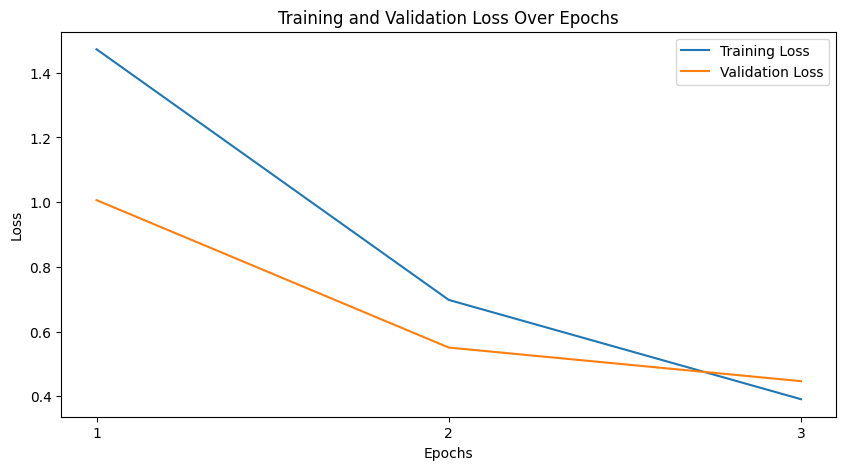

In [15]:
import matplotlib.pyplot as plt

epochs=range(1,4)
plt.figure(figsize=(10,5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()
